In [11]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Bureau/BDAI2/Satellite_Super_Resulotion0")

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

to_tensor = T.ToTensor()

def psnr(sr, hr):
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))


def compare_sr_models(
    hr_path,
    srcnn_model,
    edsr_model,
    scale=4
):
    srcnn_model.eval()
    edsr_model.eval()

    # LOAD HR
    hr_img = Image.open(hr_path).convert("RGB")
    hr_tensor = to_tensor(hr_img).unsqueeze(0).to(device)

    # GENERATE LR SYNTHETIC
    lr_img = hr_img.resize(
        (hr_img.width // scale, hr_img.height // scale),
        Image.BICUBIC
    )
    lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)

    # BICUBIC UPSCALE
    bicubic_tensor = F.interpolate(
        lr_tensor,
        scale_factor=scale,
        mode="bicubic",
        align_corners=False
    )

    # SRCNN
    with torch.no_grad():
        srcnn_sr = srcnn_model(bicubic_tensor)

    # EDSR
    with torch.no_grad():
        edsr_sr = edsr_model(lr_tensor)

    # TO NUMPY
    hr_np       = hr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    bicubic_np  = bicubic_tensor.squeeze(0).permute(1,2,0).cpu().numpy()
    srcnn_np    = srcnn_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    edsr_np     = edsr_sr.squeeze(0).permute(1,2,0).cpu().numpy()
    lr_np       = lr_tensor.squeeze(0).permute(1,2,0).cpu().numpy()

    # PSNR
    psnr_bic  = psnr(bicubic_np, hr_np)
    psnr_src  = psnr(srcnn_np, hr_np)
    psnr_edsr = psnr(edsr_np, hr_np)

    print(" PSNR RESULTS (Synthetic LR)")
    print(f"  Bicubic : {psnr_bic:.2f} dB")
    print(f"  SRCNN   : {psnr_src:.2f} dB")
    print(f"  EDSR    : {psnr_edsr:.2f} dB")

    # DISPLAY
    titles = [
        "LR (Synthetic)",
        f"Bicubic\n{psnr_bic:.2f} dB",
        f"SRCNN\n{psnr_src:.2f} dB",
        f"EDSR\n{psnr_edsr:.2f} dB",
        "HR (Ground Truth)"
    ]

    images = [lr_np, bicubic_np, srcnn_np, edsr_np, hr_np]

    plt.figure(figsize=(18, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [13]:
from src.utils.models_architecture import SRCNN, EDSR

checkpoint = torch.load(
    "src/models/checkpoints/SRCNN/best_srcnn.pth",
    map_location=device
)

srcnn = SRCNN().to(device)
srcnn.load_state_dict(checkpoint["model"])
srcnn.eval()

print("✔ SRCNN loaded correctly")

checkpoint = torch.load(
    "src/models/checkpoints/EDSR/best_EDSR.pth",
    map_location=device
)

edsr = EDSR().to(device)
edsr.load_state_dict(checkpoint["model"])
edsr.eval()

print("✔ EDSR loaded correctly")
print(f"Best PSNR during training: {checkpoint['best_psnr']:.2f} dB")

✔ SRCNN loaded correctly
✔ EDSR loaded correctly
Best PSNR during training: 28.28 dB


 PSNR RESULTS (Synthetic LR)
  Bicubic : 27.27 dB
  SRCNN   : 28.17 dB
  EDSR    : 29.42 dB


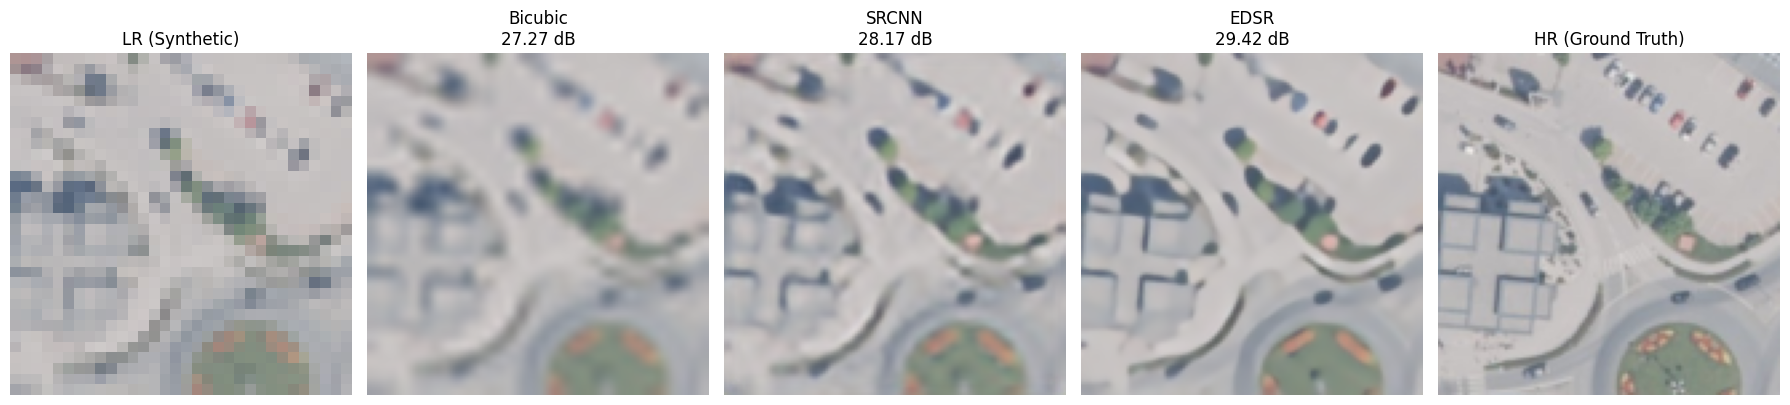

In [14]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/tyrol-e19_r14_c13.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

 PSNR RESULTS (Synthetic LR)
  Bicubic : 24.83 dB
  SRCNN   : 25.78 dB
  EDSR    : 26.54 dB


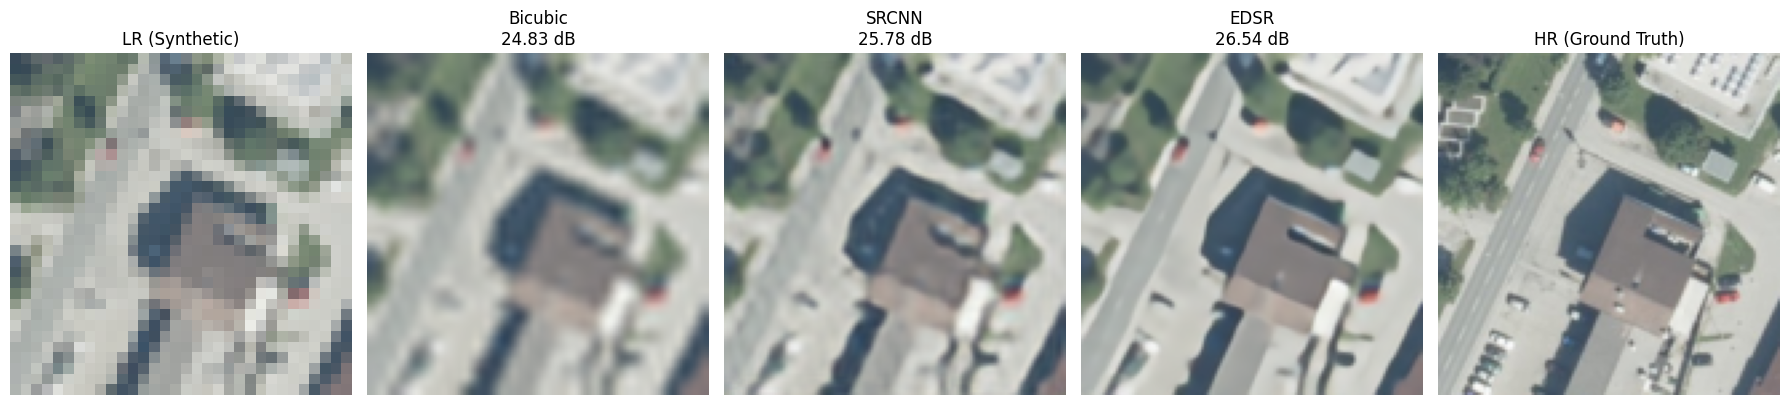

In [15]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/tyrol-w28_r22_c22.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)

 PSNR RESULTS (Synthetic LR)
  Bicubic : 27.61 dB
  SRCNN   : 28.79 dB
  EDSR    : 29.38 dB


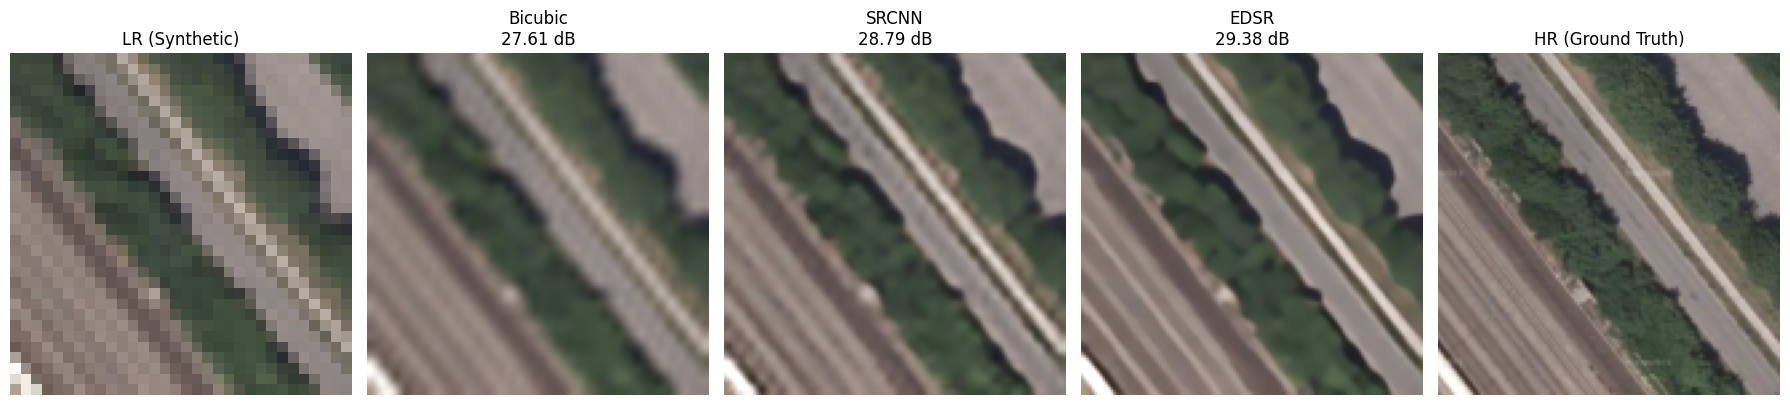

In [16]:
compare_sr_models(
    hr_path="data/preprocessed/test/HR/vienna36_r22_c19.png",
    srcnn_model=srcnn,
    edsr_model=edsr,
    scale=4
)